### Discription:
This notebook implements a Convolutional Neural Network (ConvNet) on the 'Dogs vs Cats' dataset as demonstrated in the book “Deep Learning with Python.” The code has been reproduced and executed here solely for learning and educational purposes. All original concepts and code logic belong to the book and its author, and this notebook serves only as a personal practice implementation.

## About the dataset:
* All the pictures in the dataset are JPEGs. 
* This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed).

## Approach we'll be following:
* We'll create a new dataset completely contining three parts:
1. Training set: 1000 samples from each dog and cat class
2. Validation set: 500 samples from each class again
3. Test set: 1000 samples from each class

Why not use the whole training data: As its my learning phase and im sure that im not alone in the learning phase, so in real world many of the image datasets would only contain a few thousand images, so its a good practice to learn with small datasets.

## Froming different subsets of our data:

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0 = hide all, 1 = hide INFO, 2 = hide WARNING, 3 = hide ERROR
#The above piece of code is to hide the warnings 

In [2]:
import os, shutil, pathlib

orignal_directory_path = '/kaggle/input/dogs-vs-cats/train'
orignal_directory = pathlib.Path(orignal_directory_path) #existing training data
new_base_directory = pathlib.Path('cats_vs_dogs_subset') #new directory for our subset

In [3]:
def make_subset(subset_name,start_index,end_index):
    for category in ['cat','dog']:
        dir = new_base_directory / subset_name / category
        os.makedirs(dir)
        file_names = [f'{category}.{i}.jpg'
                     for i in range(start_index,end_index)]
        for fname in file_names:
            shutil.copyfile(src= orignal_directory / fname,
                           dst= dir / fname)

make_subset('train', start_index=0, end_index=1000)
make_subset('validation', start_index=1000, end_index=1500)
make_subset('test', start_index=1500, end_index=2500)

We now have 3 subsets of the data to train, validate and run tests on. Each split/subset is a balanced one since they all contain equal number of samples from each class(i.e. Dog and Cat), it bascically becomes a binary_classification problem which makes accuracy as a good metrics to evaluate on. 

## Building the model:
This convnet model will be a stack of alternately placed Conv2D(with activation='relu') and MaxPooling layers.
We'll start from inputs of size 180 pixels x 180 pixels, and will end up with feature maps of size 7x7 just before the Flatten layer.

Since its a binary classification problem the last layer will be a dense layer with 1 unit and sigmoid activation.

We will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range. Why?? Its simple just as a grayscale images pixal is a number between 0-255 similarly in RGB images the pixal is [0-255,0-255,0-255] so 1/255 * pixal --> [0-1,0-1,0-1]. 

What are the benifits of this rescaling???
### Benefits of rescaling:
* Gradient descent works much better when inputs are normalized. The model reaches good performance in fewer epochs.
* Neural networks use many multiplications and activations. Smaller numbers = less risk of exploding values.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3), name='input_layer') #RGB images of size 180x180
x = layers.Rescaling(1./255, name='rescaling_layer') (inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='convolution_layer_1') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_1') (x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='convolution_layer_2') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_2') (x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='convolution_layer_3') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_3') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_4') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_4') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_5') (x)
x = layers.Flatten() (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs=inputs, outputs=outputs, name='classifier_convnet_1')

2026-02-07 17:26:06.988435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770485167.181665      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770485167.239736      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770485167.703856      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770485167.703905      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770485167.703908      55 computation_placer.cc:177] computation placer alr

In [5]:
model.summary()

Model: "classifier_convnet_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_1 (Conv2D)    │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_2 (Conv2D)    │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_3 (Conv2D)    │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_3 (MaxPooling2D)     │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_4 (Conv2D)    │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_4 (MaxPooling2D)     │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_5 (Conv2D)    │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model: 

In [6]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Data Preprocesssing:
Right now the data is in our directory in form of JPEGs so we'll need to:
*  Decode the JPEG content to RGB grids of pixals.
*  Convert these into floating-point tensors.
*  Resize them to a shared size of 180x180 which is input shape of our model.
*  Pack them into batches(here batch_size will be 32)

Keras features the utility function 
*image_dataset_from_directory()*
, which lets us quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_directory / 'train',
    image_size=(180,180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_directory / 'validation',
    image_size=(180,180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_directory / 'test',
    image_size=(180,180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The output of teh above piece of code are Dataset objects, it yields batches of 180  180
RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are
32 samples in each batch (the batch size).

In [8]:
for data_batch, labels_batch in train_dataset:     
    print("data batch shape:", data_batch.shape)     
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the data to the model:
We'll also pass *validation_data* argument in the **fit()** method to keep track of validation metrics.

Also using **ModelCheckpoint** callback to save the model after each epoch. Arguments *save_best_only=True* and *monitor="val_loss"* will also be passed they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
val_loss metric is lower than at any previous time during training. 
As a result, we won’t have to retrain a new model for a lower number of epochs if we start
overfitting: we can just reload our saved file.

In [9]:
#Defining teh callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "best_convnet_classifer_so_far.keras",
        save_best_only = True,
        monitor = 'val_loss')
]

#fitting data to the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30


I0000 00:00:1770485185.768960     127 service.cc:152] XLA service 0x7e8e0c004180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770485185.769009     127 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770485185.769015     127 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770485186.159646     127 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-07 17:26:28.729232: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 17:26:28.877815: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5293 - loss: 0.6972

I0000 00:00:1770485191.046741     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5108 - loss: 0.6972

2026-02-07 17:26:34.545484: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 17:26:34.690640: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.5105 - loss: 0.6972 - val_accuracy: 0.5010 - val_loss: 0.6927
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5410 - loss: 0.6939 - val_accuracy: 0.5250 - val_loss: 0.6910
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5405 - loss: 0.6906 - val_accuracy: 0.6550 - val_loss: 0.6485
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6199 - loss: 0.6662 - val_accuracy: 0.6200 - val_loss: 0.6421
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6445 - loss: 0.6253 - val_accuracy: 0.6760 - val_loss: 0.6041
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6881 - loss: 0.5784 - val_accuracy: 0.6580 - val_loss: 0.6267
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7067 - loss: 0.5544 - val_accuracy: 0.6910 - val_loss: 0.5835
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7185 - loss: 0.5412 - val_accuracy: 0.6760 - val_loss: 

## Plotting the loss and accuracy:

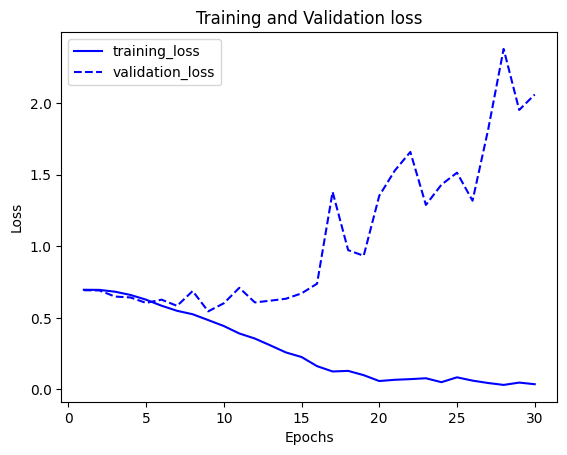

In [10]:
import matplotlib.pyplot as plt

# training_loss and val_loss on each epoch 
epochs = 30
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

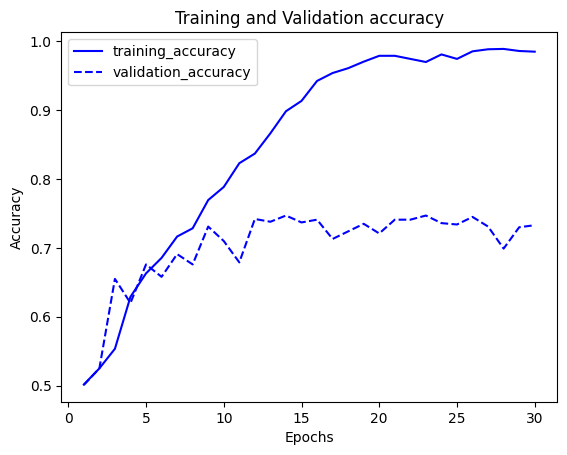

In [11]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

The above graphs showcase clear overfitting. Where training accuracy reaches 100% eventually and validation_accuracy peaks at approx 75%. Similarly validation loss reaches its lowest at epoch=10 thereafter it keeps on increasing while the training loss keeps decreasing.

## Evaluating the saved best model on test set:

In [12]:
test_model = keras.models.load_model('best_convnet_classifer_so_far.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7152 - loss: 0.6171
Test accuracy: 0.719


Test accuracy achived is in range 65-70% 

## Using Data Augmentation:
Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images.The goal is that, at training time, our model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.

### Defining a data augmentation stage/layer to add to our model:

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'), #Applies horizontal flipping to a random 50% of the images that go through it
        layers.RandomRotation(0.1), #Rotates the input images by a random value in the range [–10%, +10%]
        layers.RandomZoom(0.2), #Zooms in or out of the image by a random factor in the range [-20%, +20%]
    ]
)

For curious people who are wondering how augmentation acctually works heres a practical example:

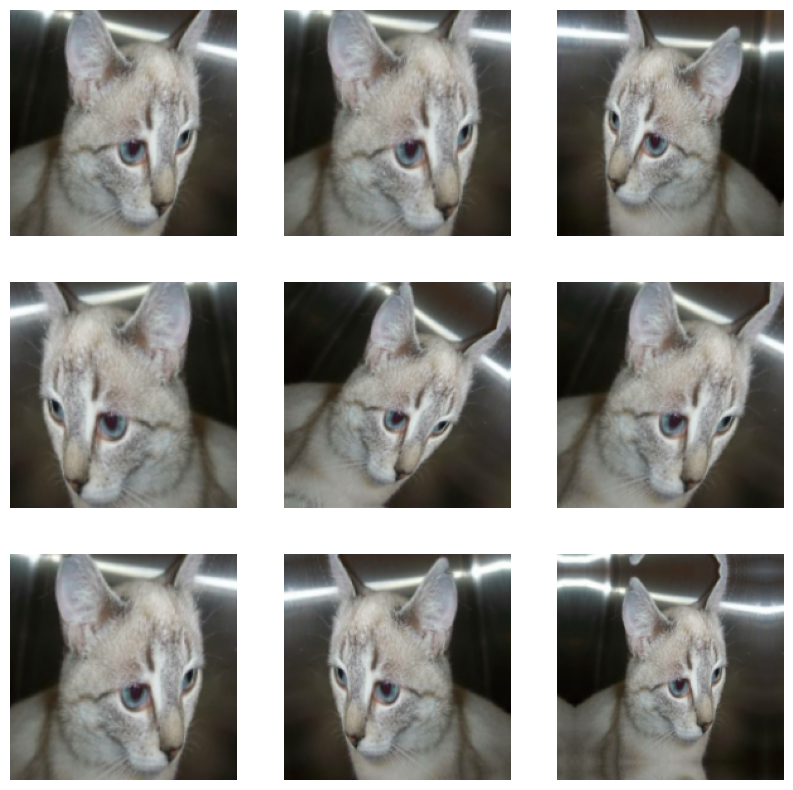

In [14]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(3):  #We can use take(N) to only sample N batches from the dataset. 
    for i in range(9):
        augmented_images = data_augmentation(images) #Apply augmentation stage to the batch of images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) #Display the first image in the output batch.For each of the nine iterations, this is a different augmentation of the same image.  
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will
never see the same input twice. But the inputs it sees are still heavily intercorrelated
because they come from a small number of original images—we can’t produce new
information; we can only remix existing information.

The augmentation wont completely get rid of overfitting so we'll also add a dropout layer right before the final output layer.

Just like Dropout, data augmentation layers are also inactive during inference (when we call predict() or evaluate()). That is during evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

## Forming a new ConvNet:

In [15]:
inputs = keras.Input(shape=(180,180,3,), name='input_layer')
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name='rescaling_layer') (inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='convolution_layer_1') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_1') (x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='convolution_layer_2') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_2') (x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='convolution_layer_3') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_3') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_4') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_4') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_5') (x)
x = layers.Flatten() (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs=inputs, outputs=outputs, name='classifier_convnet_2')

In [16]:
#compiling the new model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Training new model on training dataset:

In [17]:
#setting callbacks as last time
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_convnet_classifier_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

#tracking loss and metrics
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5096 - loss: 0.7016 - val_accuracy: 0.5630 - val_loss: 0.6898
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5367 - loss: 0.6941 - val_accuracy: 0.5400 - val_loss: 0.6929
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5814 - loss: 0.6788 - val_accuracy: 0.6130 - val_loss: 0.6601
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6392 - loss: 0.6315 - val_accuracy: 0.6470 - val_loss: 0.6333
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6721 - loss: 0.6073 - val_accuracy: 0.6420 - val_loss: 0.6162
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6867 - loss: 0.5718 - val_accuracy: 0.6550 - val_loss: 0.5973
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7247 - loss: 0.5563 - val_accuracy: 0.6850 - val_loss: 0.5933
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7440 - loss: 0.5188 - val_accuracy: 0.

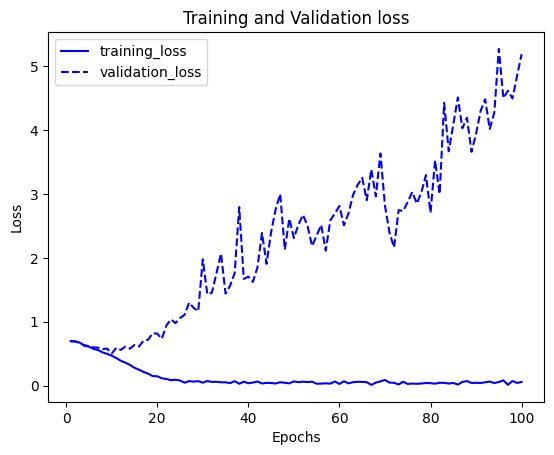

In [18]:
# training_loss and val_loss on each epoch 
epochs = 100
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

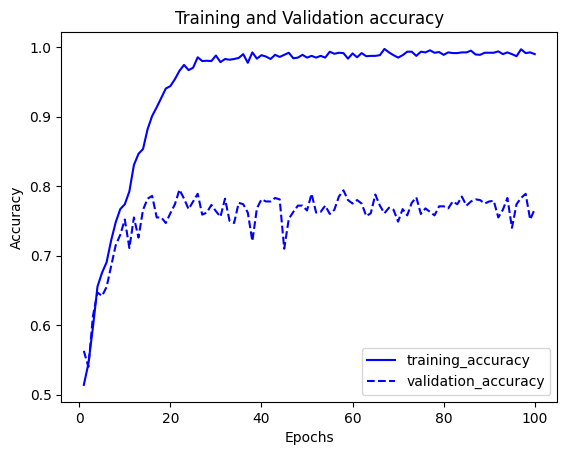

In [19]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

As can be seen the validation accuracyrange increased to around 77%-80%.

## Evaluating on test dataset:

In [24]:
best_model = keras.models.load_model('best_convnet_classifier_with_augmentation.keras')
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"test_accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7398 - loss: 0.5319
test_accuracy: 0.736


Although the model successfully implemented the complete image classification pipeline, its performance leaves room for improvement, highlighting the need for better architecture design, data augmentation, and transfer learning techniques to achieve higher accuracy and stronger generalization.